In [17]:
import string

from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.nodes import Reservoir, FORCE, AsabukiNorm, RandomChoice
from reservoirpy import combine

In [18]:
def asabuki_1alphachunks(n_timesteps,
                         chunk=('a', 'b', 'c', 'd'),
                         width=50,
                         input_gain=2,
                         min_length=5,
                         dt=1):

    alphabet = tuple(string.ascii_lowercase)
    random_elements = tuple(set(alphabet) - set(chunk))

    input_shape = np.zeros(width * 2)

    input_shape[0:width] = input_gain * (1 - np.exp(-(np.arange(0, width) / 10)))
    input_shape[width:2 * width] = input_gain * np.exp(-(np.arange(0, width) / 10))

    simtime = np.arange(0, n_timesteps * dt, dt)
    simtime_len = len(simtime)

    symbol_list = np.zeros(simtime_len)
    target_list = np.zeros(simtime_len)

    random_seq_len = np.random.randint(min_length, min_length + 4)
    random_seq = [''] * random_seq_len
    for i in range(random_seq_len):
        random_seq[i] = random_elements[
            np.random.randint(0, len(random_elements))]

    input_type = random_seq
    m = 0

    I = np.zeros((len(alphabet), simtime_len))
    for i in range(simtime_len):
        if i % width == 0 and i > 0:
            if input_type == chunk:
                if m == len(chunk) - 1:
                    random_seq_len = np.random.randint(min_length,
                                                       min_length + 4)
                    random_seq = [''] * random_seq_len
                    for l in range(random_seq_len):
                        random_seq[l] = random_elements[
                            np.random.randint(0, len(random_elements))]

                    input_type = random_seq
                    m = 0

                else:
                    input_type = chunk
                    m += 1

            elif input_type == random_seq:
                if m == len(random_seq) - 1:
                    input_type = chunk
                    m = 0

                else:
                    input_type = random_seq
                    m += 1

            I[alphabet.index(input_type[m]),
            i:min(i + width * 2, simtime_len)] = input_shape[
                                                 0:min(i + width * 2,
                                                       simtime_len) - i]

    return I.T


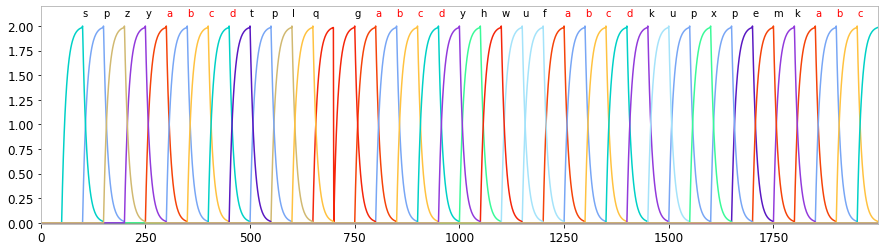

In [19]:
train_len = 500000
test_len = 2000
X = asabuki_1alphachunks(train_len + test_len)


samples = 2000
plt.figure(figsize=(15, 4))
plt.ylim(-0.01, 2.2)
for i in range(X.shape[1]):
    letter = string.ascii_lowercase[i]
    color = "red" if letter in {"a", "b", "c", "d"} else "black"
    sig = X[:samples, i]
    
    if sig.sum() > 0.0:
        plt.plot(sig)
        pos = np.where(np.isclose(sig, 2.0-1e-8))[0]
        for p in pos:
            plt.text(p, 2.1, letter, color=color)

In [20]:
dt = 1 # one timestep represents 1ms
tau = 10 # time contant of reservoirs
width = 50 # width in time of input stimuli
g_FG = 1 # feedback gain
N = 300 # number of reservoir units
n = 300 # number of synapses selected to be connected with readout
p = 1.0 # connectivity of reservoir
g = 1.5 # reservoir recurrent matrix gain
alpha = 100 # P = Id * 1/alpha (for FORCE learning)
sigma = 0.3 # noise gain
window = 300 # window for normalization
beta = 3 # coefficient for normalization
learn_every = 2 # readout is trained every 2 steps
scale = 1.0 / np.sqrt(p * N) # scale of reservoir matrix

In [21]:
M = np.zeros((N, N))
M2 = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if np.random.rand() < p:
            M[i, j] = (np.random.randn()) * g * scale
        if np.random.rand() < p:
            M2[i, j] = (np.random.randn()) * g * scale

nRec2Out = N
nIn2Rec = X.shape[1]

wo1 = np.random.randn(n, 1) / np.sqrt(n)
wo2 = np.random.randn(n, 1) / np.sqrt(n)

wf1 = (np.random.rand(N, 1) - 0.5) * 2 * g_FG
wf2 = (np.random.rand(N, 1) - 0.5) * 2 * g_FG

win = np.zeros((N, nIn2Rec))
win2 = np.zeros((N, nIn2Rec))

for i in range(N):
    win[i, np.random.randint(0, nIn2Rec)] = np.random.randn()
    win2[i, np.random.randint(0, nIn2Rec)] = np.random.randn()

100%|██████████████████████████████████| 485000/485000 [10:31<00:00, 767.97it/s]


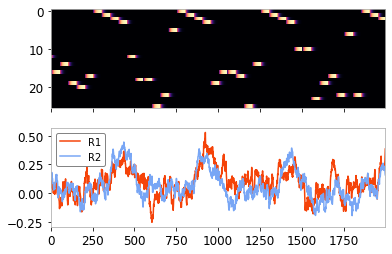

In [22]:
# leak rate is dt/tau by definition
# noise is multiplied by leak rate in reservoirpy, hence the corrective factor (tau/dt)
res1 = Reservoir(N, lr=dt/tau, input_bias=False, rc_connectivity=p,
                 W=M, Win=win,
                 Wfb=wf1,
                 noise_rc=sigma * np.sqrt(dt) * (tau/dt),
                 noise_type="normal",
                 equation="external",
                 name="h1")

res2 = Reservoir(N, lr=dt/tau, input_bias=False, rc_connectivity=p,
                 W=M2, Win=win2,
                 Wfb=wf2,
                 noise_rc=sigma * np.sqrt(dt) * (tau/dt),
                 noise_type="normal",
                 equation="external",
                 name="h2")


read1 = FORCE(1, alpha=alpha, name="r1", Wout_init=wo1, input_bias=False)
read2 = FORCE(1, alpha=alpha, name="r2", Wout_init=wo2, input_bias=False)

norm1 = AsabukiNorm(window=window * width, beta=beta)
norm2 = AsabukiNorm(window=window*width, beta=beta)

# this is our training model
branch1 = res1 >> RandomChoice(n=n) >> read1
branch2 = res2 >> RandomChoice(n=n) >> read2
model = combine(branch1, branch2)

# to warmup the special normalization node, we also build a 
# transient model
trans1 = branch1 >> norm1
trans2 = branch2 >> norm2
transient_model = combine(branch1, branch2)

# feedack connections
read1 << (read2 >> norm2)
read2 << (read1 >> norm1)
res1 << read1
res2 << read2

init_states = {"h1": 0.5 * np.random.randn(1, N),
               "h2": 0.5 * np.random.randn(1, N),
               "r1": 0.5 * np.random.randn(1, 1),
               "r2": 0.5 * np.random.randn(1, 1)}

# first, warmup the nodes a bit to be sure the rolling window of the normalization
# nodes is full of real data
transients = width * window

transient_model.run(X[:transients], from_state=init_states)

# then, train the model
model.train(X[transients:train_len], learn_every=learn_every,
            force_teachers=False)

# test the model
res = model.run(X[train_len:])

fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
ax0.imshow(X[train_len:].T, aspect="auto", interpolation="none")
ax1.plot(res["r1"], label="R1")
ax1.plot(res["r2"], label="R2")
plt.legend()
plt.show()